In [1]:
%matplotlib inline

In [2]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Embedding size
m = 16

# Hidden size
hidden_size = 32

# Stack initialized?
init = False

# RNN vars
max_length  = 100
vocab_size  = 10         # Input vocabulary
in_seq_length  = 20
out_seq_length  = 20
batch_size  = 32

In [4]:
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.2)
sess = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))

In [5]:
s = None
V = None

In [6]:
# Pop operation helpers
def check(stack, strengths, remaining, read, idx):
    # Bottom of stack
    return idx >= 0 #tf.logical_and(idx >= 1, remaining != 0)

def update(stack, strengths, remaining, read, idx):
    # Amount we can use at this step
    this_qty = tf.minimum(remaining, strengths[:,:,idx:idx+1])

    # Update read value
    old_read = read
    read = tf.reshape(read + tf.reshape(this_qty * V[:,:,idx:idx+1], tf.shape(read)), tf.shape(read))  # for shape constraints

    # Update remaining strength
    remaining = tf.reshape(remaining - this_qty, tf.shape(remaining))

    # Update strengths
    before = strengths[:,:,:idx]
    this   = tf.reshape(tf.sub(strengths[:,:,idx:idx+1], this_qty), (-1, 1, 1))
    after  = strengths[:,:,idx+1:]

    strengths = tf.reshape(tf.concat(2, [before, this, after]), tf.shape(strengths), name="strength_cat")

    # Update index
    idx = idx - 1

    return (stack, strengths, remaining, read, idx)

In [7]:
def stack_update(d, u, v):
    '''
    Performs an update to the neural stack.
    
    Args:
      d: Push probability.
      u: Pop probability.
      v: Push value.
    
    Returns:
      r: The value read from the stack.
    '''
    global s, V, m, init
    
    # Change shapes
    d = tf.expand_dims(d, -1)
    u = tf.expand_dims(u, -1)
    v = tf.expand_dims(v, -1)
    
    # Infer batch size
    batch_size = tf.shape(d)[0]
    
    if init:
        # Infer stack size
        stack_size = tf.shape(V)[2]
        
        # Perform initializations
        read0     = tf.zeros((batch_size, m))      # Read value
        idx0      = stack_size - 1                  # Index into the stack
        
        initialization = (V, s, u, read0, idx0)
        pop_operation = tf.while_loop(check, update, initialization)
        
        # Update strengths and perform read
        s = pop_operation[1]
        r = pop_operation[3]
        
        # Perform push
        V = tf.concat(2, [V, v])
        s = tf.concat(2, [s, d])
        
    else:
        r = tf.zeros((batch_size, m), dtype=np.float32)
        init = True
        
        # Initialize stack
        V = v
        s = d
    
    return r

In [8]:
def one_hotify(vector, output_vocabulary_size):
    # Create the result vector
    vector_one_hot = np.zeros(list(vector.shape) + [output_vocabulary_size])
    
    # Use fancy indexing to activate positions
    vector_one_hot[list(np.indices(vector.shape)) + [vector]] = 1
    
    return vector_one_hot

In [9]:
inputs = [tf.placeholder(tf.int32, shape=(batch_size,), name="inp%i" % t) for t in range(in_seq_length)]
labels = [tf.placeholder(tf.int32, shape=(batch_size,), name="labels%i" % t) for t in range(out_seq_length)]
weights = [tf.ones_like(label, dtype=tf.float32) for label in labels]

In [10]:
one_hot_inputs = [tf.one_hot(input_, vocab_size + 1) for input_ in inputs]

In [11]:
# For padding the input to get an output
input_padding = [tf.constant(one_hotify(np.array([vocab_size] * batch_size), vocab_size + 1), dtype=tf.float32, name="pad%i" % t) for t in range(out_seq_length)]

In [12]:
cell = tf.nn.rnn_cell.GRUCell(hidden_size)
state = cell.zero_state(batch_size, tf.float32)
outputs = []

In [13]:
# For getting the push probability
W_d = tf.Variable(tf.random_normal((hidden_size, 1), stddev=0.01))
b_d = tf.Variable(np.array([-1]), dtype=tf.float32)

# For getting the pop probability
W_u = tf.Variable(tf.random_normal((hidden_size, 1), stddev=0.01))
b_u = tf.Variable(np.array([-1]), dtype=tf.float32)

# For getting the value to be pushed
W_v = tf.Variable(tf.random_normal((hidden_size, m), stddev=0.01))
b_v = tf.Variable(np.zeros((m,)), dtype=tf.float32)

# For getting the output produced
W_o = tf.Variable(tf.random_normal((hidden_size, vocab_size), stddev=0.01))
b_o = tf.Variable(np.zeros((vocab_size,)), dtype=tf.float32)

In [14]:
# Initialize first read to all 0's
r_t = tf.zeros((batch_size, m))
d_log = []
u_log = []
v_log = []

with tf.variable_scope('rnn_unfolding') as varscope:
    for input_ in one_hot_inputs + input_padding:
        combined_input = tf.concat(1, [input_, r_t])
        output, state  = cell(combined_input, state)
        
        # Calculate d, u, v
        d_t = tf.sigmoid(tf.matmul(output, W_d) + b_d)
        u_t = tf.sigmoid(tf.matmul(output, W_u) + b_u)
        v_t = tf.tanh(tf.matmul(output, W_v) + b_v)
        o_t = tf.tanh(tf.matmul(output, W_o) + b_o)
        
        d_log.append(d_t)
        u_log.append(u_t)
        v_log.append(v_t)
        
        # Perform stack operation
        r_t = stack_update(d_t, u_t, v_t)
        
        if input_ in input_padding:
            outputs.append(o_t)
        
        varscope.reuse_variables()

In [15]:
# Loss
loss = tf.nn.seq2seq.sequence_loss(outputs, labels, weights, vocab_size)

In [16]:
# Predictions
predictions = [tf.cast(tf.argmax(output_t, 1), tf.int32) for output_t in outputs]

In [17]:
# Accuracy
accuracy_numerator = tf.add_n([tf.reduce_sum(tf.cast(tf.equal(pred_t, label_t), tf.float32)) for (pred_t, label_t) in zip(predictions, labels)])
accuracy_denominator = tf.add_n([tf.reduce_prod(tf.cast(tf.shape(label_t), tf.float32)) for label_t in labels])
accuracy = accuracy_numerator/accuracy_denominator

In [18]:
# Optimizer
train_op = tf.train.AdamOptimizer().minimize(loss)

In [19]:
saver = tf.train.Saver()

In [20]:
# Initialize
# sess.run(tf.initialize_all_variables())

# Load
saver.restore(sess, 'checkpoints/seq2seq')

In [21]:
# Train
# losses     = []

# for iter_ in range(2 * 10 ** 4):
#     # Generate samples randomly
#     x_   = np.random.randint(0, vocab_size, (batch_size, in_seq_length))
#     y_   = x_[:,::-1]
    
#     # Calculate loss and backprop
#     feed_dict = {inputs[t]: x_[:,t] for t in range(in_seq_length)}
#     feed_dict.update({labels[t]: y_[:,t] for t in range(out_seq_length)})
#     loss_t, acc_t, _ = sess.run((loss, accuracy, train_op), feed_dict)
    
#     losses.append(loss_t)
    
#     if iter_ % 10 == 0 and iter_ > 0:
#         print 'Iteration: %5d Loss: %3.4f Accuracy: %3d%%' % (iter_, loss_t, acc_t * 100)

In [22]:
x_foo = np.random.randint(0, vocab_size, (batch_size, in_seq_length))
feed_dict_foo = {inputs[t]: x_foo[:,t] for t in range(in_seq_length)}

u_foo = sess.run(u_log, feed_dict_foo)
d_foo = sess.run(d_log, feed_dict_foo)
V_foo = sess.run(V, feed_dict_foo)

In [23]:
np.shape(u_foo)

(40, 32, 1)

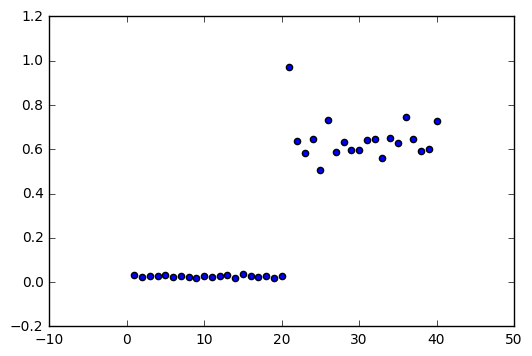

In [24]:
plt.scatter(range(1, 41), np.array(u_foo)[:,0,0])

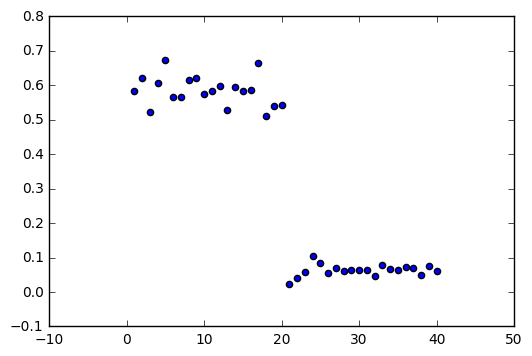

In [25]:
plt.scatter(range(1, 41), np.array(d_foo)[:,0,0])

In [26]:
# saver.save(sess, 'checkpoints/seq2seq')